# Sentiment Analysis on Movie Reviews
## Part 2. Multiclass classification

In [48]:
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import unicodedata, re

## Preparation and analisys of data

In [2]:
# load data
train = pd.read_csv('train_3.tsv', '\t')
test = pd.read_csv('test.tsv', '\t')

In [3]:
# shapes of datasets
print("Train :",train.shape)
print("Test:",test.shape)

Train : (156060, 4)
Test: (66292, 3)


In [4]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Колонка ['Sentiment'] містить оцінку коментаря (від 0 до 4). Відповідно:

0 - негативний;
1 - трохи негативний;
2 - нейтральний;
3 - трохи позитивний;
4 - позитивний.

In [5]:
train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [6]:
# get columns with NULLs  (if exist)
train.columns[train.isna().any()].tolist()

[]

Оглянемо, скільки фраз належить до одного речення (наприклад, до речення 2):

In [7]:
sentence_2 = train.loc[train['SentenceId'] == 2]
print(len(sentence_2))
sentence_2

18


,PhraseId,SentenceId,Phrase,Sentiment
63,64,2,"This quiet , introspective and entertaining in...",4
64,65,2,"This quiet , introspective and entertaining in...",3
65,66,2,This,2
66,67,2,"quiet , introspective and entertaining indepen...",4
67,68,2,"quiet , introspective and entertaining",3
68,69,2,quiet,2
69,70,2,", introspective and entertaining",3
70,71,2,introspective and entertaining,3
71,72,2,introspective and,3
72,73,2,introspective,2


In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [9]:
test.columns[test.isna().any()].tolist()

[]

І в тренувальному, і в тестувальному датасеті відсутні нульові значення, тому не потрібно виконувати їхню додаткову обробку.

Відслідкуємо кількість фраз за оцінкою:

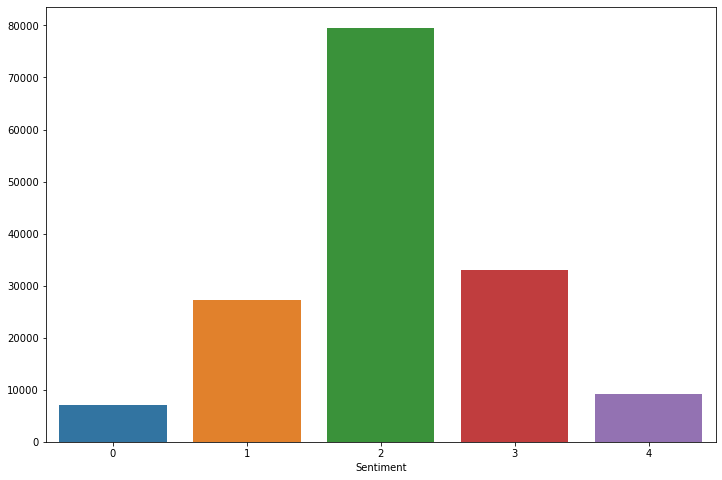

In [10]:
dist = train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

Оскільки на оцінку коментаря (негативний/позитивний) впливають лише слова у фразі, то саме з них і сформуємо матрицю властивостей (feature matrix).

Нормалізуємо текстові дані:

In [11]:
# For text cleaning

RE_LINE_BREAK = re.compile('\\n+', re.M)
RE_CITATION = re.compile('^.*writes:$', re.M)
RE_CITATION_QUOTES = re.compile('(\W+|^)(\|>|>|\|)+', re.M)
STOP_WORDS = set(stopwords.words('english'))
STEMMER = PorterStemmer()

TEXT_LENS = []

def _clean(docs):
    docs = map(rm_citation, docs)
    docs = map(rm_citation_quotes, docs)
    docs = map(rm_nums, docs)
    docs = map(rm_line_break, docs)
    docs = map(to_lower, docs)
    docs = map(rm_stopwords, docs)
    docs = map(rm_too_short_long, docs)
    docs = map(stem_words, docs)
    
    return list(docs)

def rm_citation(doc):
    return RE_CITATION.sub('', doc)

def rm_citation_quotes(doc):
    return RE_CITATION_QUOTES.sub(r'\1', doc)

def rm_line_break(doc):
    return RE_LINE_BREAK.sub(' ', doc).strip('\n\t ')

def rm_nums(doc):
    return re.sub('[^a-zA-Z]', ' ', doc)

def to_lower(doc):
    return doc.lower()

def rm_stopwords(doc):
    doc = doc.split()
    doc = [w for w in doc if not w in STOP_WORDS]
    return ' '.join(doc)

def rm_too_short_long(doc):
    doc = doc.split()
    doc = [w for w in doc if len(w) >=3 and len(w) <= 15]
    return ' '.join(doc)

def stem_words(doc):
    doc = doc.split()
    doc = [STEMMER.stem(w) for w in doc]
    TEXT_LENS.append(len(doc))
    return ' '.join(doc)

In [12]:
df_train = pd.DataFrame.from_dict({
        'Phrase': _clean(train.Phrase),
        'Sentiment': train.Sentiment
    })
df_train

,Phrase,Sentiment
0,seri escapad demonstr adag good goos also good...,1
1,seri escapad demonstr adag good goos,2
2,seri,2
3,,2
4,seri,2
...,...,...
156055,hearst,2
156056,forc avuncular chortl,1
156057,avuncular chortl,3
156058,avuncular,2


In [13]:
df_test = pd.DataFrame.from_dict({
        'Phrase': _clean(test.Phrase)
    })
df_test

,Phrase
0,intermitt pleas mostli routin effort
1,intermitt pleas mostli routin effort
2,
3,intermitt pleas mostli routin effort
4,intermitt pleas mostli routin
...,...
66287,long wind predict scenario
66288,long wind predict scenario
66289,long wind
66290,long wind


### Split train data into train and train_for_test set

Тренувальний датасет розділимо на тренувальну і тестувальну частину, щоб зробити перевірку, бо в тестувальному датасеті відсутня колонка з оцінками.

In [14]:
train, train_for_test = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train.Sentiment)

#### Train set:

In [15]:
train.shape

(124848, 2)

#### Train_for_test set:

In [16]:
train_for_test.shape

(31212, 2)

#### Train-Set label distribution:

In [17]:
train.Sentiment.value_counts()

2    63665
3    26342
1    21818
4     7365
0     5658
Name: Sentiment, dtype: int64

#### Train_for_test-Set label distribution:

In [18]:
train_for_test.Sentiment.value_counts()

2    15917
3     6585
1     5455
4     1841
0     1414
Name: Sentiment, dtype: int64

### Encode text using TF-IDF

Створимо словник унікальних слів за допомогою TfIdfVectorizer:

In [19]:
# Lenght of the longest text - compute with text cleaning
max(TEXT_LENS)

29

In [20]:
tfidf = TfidfVectorizer(max_features=max(TEXT_LENS)).fit(train.Phrase)

In [21]:
keys = sorted((key, token) for token, key in tfidf.vocabulary_.items())
keys[:10]

[(0, 'bad'),
 (1, 'charact'),
 (2, 'come'),
 (3, 'comedi'),
 (4, 'director'),
 (5, 'even'),
 (6, 'feel'),
 (7, 'film'),
 (8, 'funni'),
 (9, 'get')]

Закодуємо фрази відповідно до словника:

In [22]:
X_train = tfidf.transform(train.Phrase).toarray()
print('X_train shape: %s' % (X_train.shape,))

X_train_for_test = tfidf.transform(train_for_test.Phrase).toarray()
print('X_train shape: %s' % (X_train_for_test.shape,))

X_test = tfidf.transform(test.Phrase).toarray()
print('X_test shape: %s' % (X_test.shape,))

X_train shape: (124848, 29)
X_train shape: (31212, 29)
X_test shape: (66292, 29)


### Target label

Колонка Sentiment, яку передбачаємо, складається з цілочислових значень.

In [23]:
Y_train = train.Sentiment
print('Y_train shape: %s' % (Y_train.shape,))

Y_train_for_test = train_for_test.Sentiment
print('Y_train_for_test shape: %s' % (Y_train_for_test.shape,))

Y_train shape: (124848,)
Y_train_for_test shape: (31212,)


### Create ColumnTransformer for sklearn pipeline

In [24]:
features = "Phrase"
transformer = Pipeline([("tfidf", TfidfVectorizer())])

In [25]:
preprocessor = ColumnTransformer(transformers=[('cat', transformer, features)])

##  Algorithm selection

### 1. Classification with custom Neural Network

#### Transform Y_train:

In [26]:
Y_train_transf = OneHotEncoder().fit_transform(Y_train.values.reshape(-1, 1)).toarray()
print(Y_train)
print(Y_train_transf)
Y_train_transf.shape

35876     2
56148     3
125229    0
107990    4
24483     4
         ..
134537    3
21579     1
89654     2
49277     2
85772     2
Name: Sentiment, Length: 124848, dtype: int64
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


(124848, 5)

In [27]:
class NeuralNet:
    """
    
    NN for multi-class classification with mini-batch
    Attributes:
    ...
    """    
    def __init__(self, mbgd_size, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.mbgd_size = mbgd_size
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
    
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        eZ = np.exp(Z - np.max(Z))
        return eZ / np.sum(eZ, axis=0, keepdims=True)

    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * np.sqrt(1 / neurons_in_layers[i - 1])
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1))
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__softmax(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__softmax(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        return AL, caches
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__softmax(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__sigmoid(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
   
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def __shuffle_and_separate(self, X, Y):            
        m = X.shape[1]
        SS_data = [] #for shuffled and separated data
        mbgd_size = self.mbgd_size
        
        perm = list(np.random.permutation(m))
        shuff_X = X[:, perm]        
        shuff_Y = Y[:, perm]

        for i in range(0, int(np.floor(m/mbgd_size))):
            batch_X = shuff_X[:, i*mbgd_size : (i + 1)*mbgd_size]
            batch_Y = shuff_Y[:, i*mbgd_size : (i + 1)*mbgd_size]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        if m % mbgd_size != 0:
            batch_X = shuff_X[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            batch_Y = shuff_Y[:, int(np.floor(m/mbgd_size))*mbgd_size:]
            
            batch = (batch_X, batch_Y)
            SS_data.append(batch)

        return SS_data
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        m = X.shape[1]
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            SS_data = self.__shuffle_and_separate(X, Y)
            
            for (batch_X, batch_Y) in SS_data:
                A, caches = self.__forward_propagation(batch_X)

                cost = self.compute_cost(A, batch_Y)

                grads = self.__backward_propagation(A, batch_Y, caches)

                self.__update_parameters(grads)
            
            costs.append(cost)

            if print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        return np.argmax(positive_probs, axis = 1)

#### Hyperparameters (the best combination):

In [28]:
alpha = 0.01
max_iters = 100
minibatch_size = 4096
input_layer = X_train.shape[1]
output_layer = Y_train_transf.shape[1]

In [29]:
clf = NeuralNet(mbgd_size = minibatch_size, neurons_in_layers = [input_layer, 145, output_layer], normalize = True, learning_rate = alpha, num_iter = max_iters)

0-th iteration: 0.31411619858355594
10-th iteration: 0.2718415344029665
20-th iteration: 0.26370589689687524
30-th iteration: 0.2570326798468153
40-th iteration: 0.255280688933139
50-th iteration: 0.25722018039774447
60-th iteration: 0.2495710566930688
70-th iteration: 0.2532145059488554
80-th iteration: 0.2548332780682198
90-th iteration: 0.2560235061977599


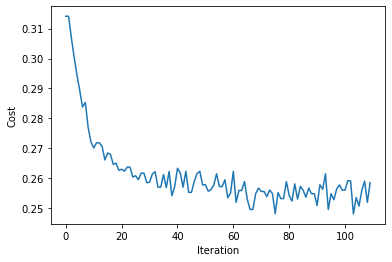

In [30]:
clf.fit(X_train, Y_train_transf)

In [31]:
Y_train_pred = clf.predict(X_train)
print(Y_train_pred)

[2 2 2 ... 2 2 2]


In [32]:
Y_train_for_test_pred = clf.predict(X_train_for_test)
print(Y_train_for_test_pred)

[2 2 2 ... 2 2 2]


Передбачаємо також тестові дані, але не перевірятимемо їх, бо немає колонки Sentiment.

In [33]:
Y_test_pred = clf.predict(X_test)
print(Y_test_pred)

[2 2 2 ... 2 2 2]


#### Results evaluation for train data:

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5658
           1       0.00      0.00      0.00     21818
           2       0.51      1.00      0.68     63665
           3       0.00      0.00      0.00     26342
           4       0.00      0.00      0.00      7365

    accuracy                           0.51    124848
   macro avg       0.10      0.20      0.14    124848
weighted avg       0.26      0.51      0.34    124848

Confusion matrix:


c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AxesSubplot(0.125,0.125;0.62x0.755)


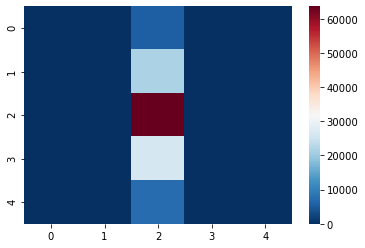

In [34]:
print("Classification report:")
print(classification_report(Y_train, Y_train_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train, Y_train_pred), cmap="RdBu_r"))

#### Results evaluation for train_for_test data:

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1414
           1       0.00      0.00      0.00      5455
           2       0.51      1.00      0.68     15917
           3       0.00      0.00      0.00      6585
           4       0.00      0.00      0.00      1841

    accuracy                           0.51     31212
   macro avg       0.10      0.20      0.14     31212
weighted avg       0.26      0.51      0.34     31212

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


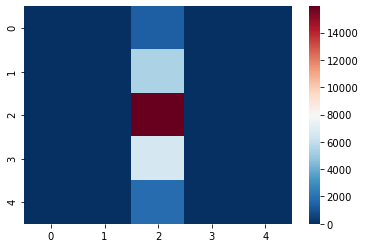

In [35]:
print("Classification report:")
print(classification_report(Y_train_for_test, Y_train_for_test_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train_for_test, Y_train_for_test_pred), cmap="RdBu_r"))

### 2. Sklearn classifier

In [36]:
svc = LinearSVC().fit(X_train, Y_train)

In [37]:
Y_train_pred = svc.predict(X_train)
Y_train_pred

array([2, 3, 2, ..., 2, 2, 2], dtype=int64)

In [38]:
Y_train_for_test_pred = svc.predict(X_train_for_test)
Y_train_for_test_pred

array([2, 2, 3, ..., 2, 2, 2], dtype=int64)

#### Results evaluation for train data:

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5658
           1       0.35      0.03      0.05     21818
           2       0.53      0.97      0.69     63665
           3       0.39      0.10      0.16     26342
           4       1.00      0.00      0.00      7365

    accuracy                           0.52    124848
   macro avg       0.46      0.22      0.18    124848
weighted avg       0.47      0.52      0.39    124848

Confusion matrix:


c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AxesSubplot(0.125,0.125;0.62x0.755)


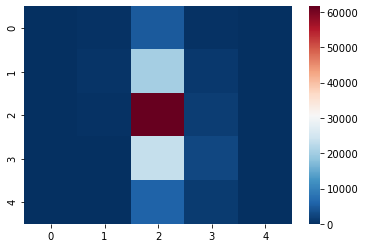

In [39]:
print("Classification report:")
print(classification_report(Y_train, Y_train_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train, Y_train_pred), cmap="RdBu_r"))

#### Results evaluation for train_for_test data:

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1414
           1       0.38      0.03      0.05      5455
           2       0.53      0.97      0.68     15917
           3       0.38      0.10      0.16      6585
           4       1.00      0.00      0.00      1841

    accuracy                           0.52     31212
   macro avg       0.46      0.22      0.18     31212
weighted avg       0.47      0.52      0.39     31212

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


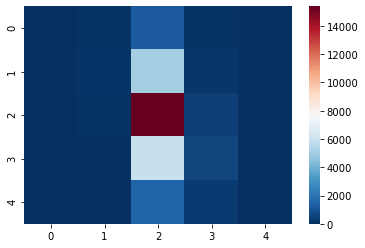

In [40]:
print("Classification report:")
print(classification_report(Y_train_for_test, Y_train_for_test_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train_for_test, Y_train_for_test_pred), cmap="RdBu_r"))

### 3. Hyperparameter selection

In [41]:
X_train3 = df_train.drop(columns = ['Sentiment'])
Y_train3 = df_train.drop(columns = ['Phrase'])

#### Create new pipeline:

In [42]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ('classifier', LinearSVC())])

In [43]:
pipeline.fit(X_train3, Y_train3)

c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('tfidf',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                                                                                   encoding='utf-8',
                                      

In [44]:
Y_train_pred = pipeline.predict(X_train3)

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.35      0.45      7072
           1       0.61      0.49      0.54     27273
           2       0.72      0.88      0.79     79582
           3       0.61      0.53      0.57     32927
           4       0.67      0.36      0.47      9206

    accuracy                           0.68    156060
   macro avg       0.65      0.52      0.57    156060
weighted avg       0.67      0.68      0.67    156060

Confusion matrix:
AxesSubplot(0.125,0.125;0.62x0.755)


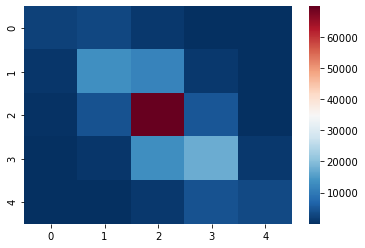

In [45]:
print("Classification report:")
print(classification_report(Y_train3, Y_train_pred))
print("Confusion matrix:")
print(sns.heatmap(confusion_matrix(Y_train3, Y_train_pred), cmap="RdBu_r"))

#### Using GridSearch to search the best hyperparams:

In [46]:
# Possible parameters:
param_grid = {
    'solver': ['adam'],
    'max_iter': [100, 50],
    'learning_rate_init': [0.1, 0.01],
    'hidden_layer_sizes': [(100,), (50,)],
    'random_state': [42]
}

search = GridSearchCV(MLPClassifier(), param_grid, n_jobs=-1)

search.fit(X_train, Y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.523):
{'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 100, 'random_state': 42, 'solver': 'adam'}


c:\users\vika\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [49]:
accuracy_score(Y_train_for_test, search.predict(X_train_for_test))

0.5208253235934897